In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import APSIMGraphHelpers as AGH
import GraphHelpers as GH
import matplotlib.dates as mdates
import MathsUtilities as MUte
import sqlite3

In [16]:
Colors = {1:'#000000',
2:'#E69F00',
3:'#56B4E9',
4:'#009E73',
5:'#F0E442',
6:'#0072B2',
7:'#D55E00',
8:'#CC79A7',
9:'#1F77B4',
10:'#AEC7E8',
11:'#FF7F0E',
12:'#FFBB78',
13:'#2CA02C',
14:'#98DF8A',
15:'#D62728',
16:'#FF9896',
17:'#9467BD',
18:'#C5B0D5',
19:'#8C564B',
20:'#C49C94',
21:'#E377C2',
22:'#F7B6D2',
23:'#7F7F7F',
24:'#C7C7C7',
25:'#BCBD22',
26:'#DBDB8D',
27:'#17BECF',
28:'#9EDAE5'}

Markers = {1: 'o',
 2: '^',
 3: 's',
 4: '*',
 5: '>',
 6: 'v',
 7: '+',
 8: 'X',
 9: '<',
 10: 'p',
 11: '8',
 12: 'd',
 13:'P',
 14:'D',
 15:'o',
 16:'^'}

Lines = {1: '-',
 2: '--',
 3: '-,',
 4: ':',
 5: '-',
 6: '--',
 7: '-,',
 8: ':',
 9: '-',
 10: '--',
 11: '-,',
 12: ':',
 13: '-',
 14: '--',
 15: '-,',
 16: ':'}

In [2]:
MasterfilePath = r'C:\GitHubRepos\ApsimX\Tests\Validation\Wheat\Wheat.db'

In [3]:
con = sqlite3.connect(MasterfilePath)
Simulations = pd.read_sql("Select * from _Simulations",con)
con.close()
Simulations.set_index('ID',inplace=True)
Simulations.sort_index(inplace=True)
Simulations.sort_index(inplace=True, axis=1)

In [4]:
SensibilityFolders = ['CO2AndTranspirationEfficiency',
'CO2AndTemperatureInteractions',
'ProteinAccumulation',
'LeafAppearance',
'TerminalWaterStress',
'DetailedDynamics']

In [5]:
con = sqlite3.connect(MasterfilePath)
HarvestPred = pd.read_sql("Select * from HarvestReport",con).dropna(axis=1,how='all')
con.close()
HarvestPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in HarvestPred.SimulationID]
HarvestPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
HarvestPred.sort_index(inplace=True)
HarvestPred.sort_index(inplace=True,axis=1)

# Filter outputs from sensibility tests
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)
HarvestPred.loc[:,'Wheat.SowingData.Cultivar'] = [x.title() for x in HarvestPred.loc[:,'Wheat.SowingData.Cultivar']]
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)

# Replace Experiment with values that have had folder name pathed in where no experiment is present
HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'Experiment'] = HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'FolderName']

In [6]:
SowIndices = ['IWeather.Latitude',
    'IWeather.Longitude',
    'LocationInfo.Script.Country',
    'LocationInfo.Script.Region',
    'LocationInfo.Script.State',
    'Wheat.SowingData.Cultivar',
    'Experiment',
    'FolderName']

def getValue(ind,var,HarvestPred):
    try:
        return HarvestPred.loc[ind,var].values[0]
    except:
        return ""

con = sqlite3.connect(MasterfilePath)
Observed = pd.read_sql("Select * from Observed",con).dropna(axis=1,how='all')
con.close()
Observed.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in Observed.SimulationID]
Observed.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
Observed.sort_index(inplace=True)
Observed.sort_index(inplace=True,axis=1)
for s in SowIndices:
    Observed.loc[:,s] = [getValue(x,s,HarvestPred) for x in Observed.index.get_level_values(0)]

In [7]:
con = sqlite3.connect(MasterfilePath)
DailyPred = pd.read_sql("Select * from DailyReport",con)
con.close()
DailyPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in DailyPred.SimulationID]
DailyPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
DailyPred.sort_index(inplace=True)
DailyPred.sort_index(inplace=True,axis=1)
validationFilter = [x not in SensibilityFolders for x in DailyPred.FolderName]
DailyPred = DailyPred.loc[validationFilter,:].copy()
DailyPred.dropna(how='all',axis=1,inplace=True)
# Replace Experiment with values that have had folder name pathed in where no experiment is present
DailyPred.loc[:,'Experiment'] = [HarvestPred.loc[x,'Experiment'] for x in DailyPred.index.get_level_values(0)]

## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']

In [8]:
## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']

In [10]:
MasterIndexVars = ['Clock.Today',
'IWeather.MaxT',
'IWeather.MinT',
'IWeather.Radn',
'SimulationID',
'SimulationName',
'Wheat.DaysAfterSowing',
'Wheat.Phenology.AccumulatedTT',
'Wheat.Phenology.PTQ',
'Wheat.Phenology.CurrentPhaseName',
'Wheat.Phenology.CurrentStageName',
'Wheat.Phenology.Stage']

for iv in MasterIndexVars:
    Observed.loc[:,iv] = DailyPred.reindex(Observed.index).loc[:,iv]

Text(0.5, 0, 'Stem.Wt')

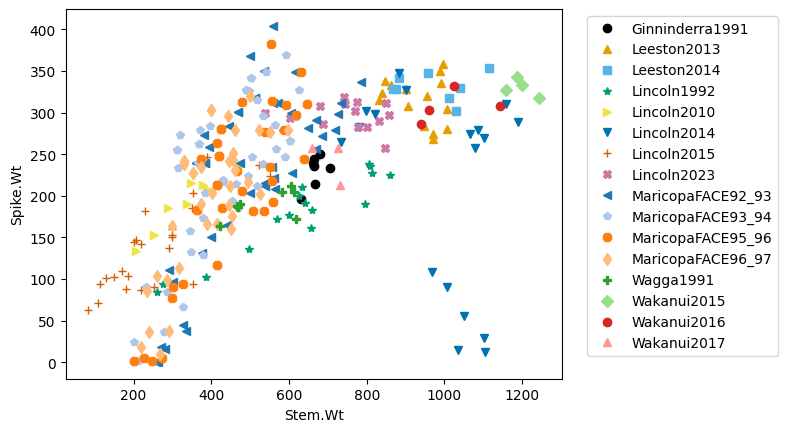

In [63]:
vars = ['Wheat.Spike.Wt','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,vars[1]],exData.loc[:,vars[0]],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('Spike.Wt')
plt.xlabel('Stem.Wt')

Text(0.5, 0, 'Phenology.Stage')

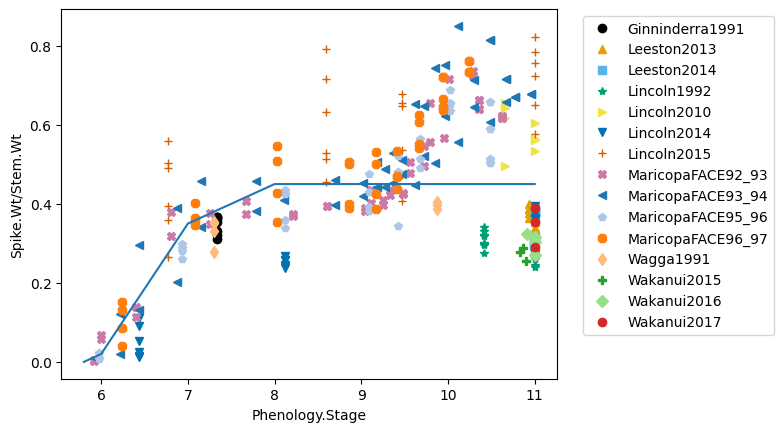

In [61]:
vars = ['Wheat.Spike.Wt','Wheat.Phenology.Stage','Wheat.Stem.Wt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Spike.Wt']/exData.loc[:,'Wheat.Stem.Wt'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.plot([5.8,6.0,7.0,8.0,11.0],
         [0.0,.02,.35,.45,.45],'-')
plt.ylabel('Spike.Wt/Stem.Wt')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

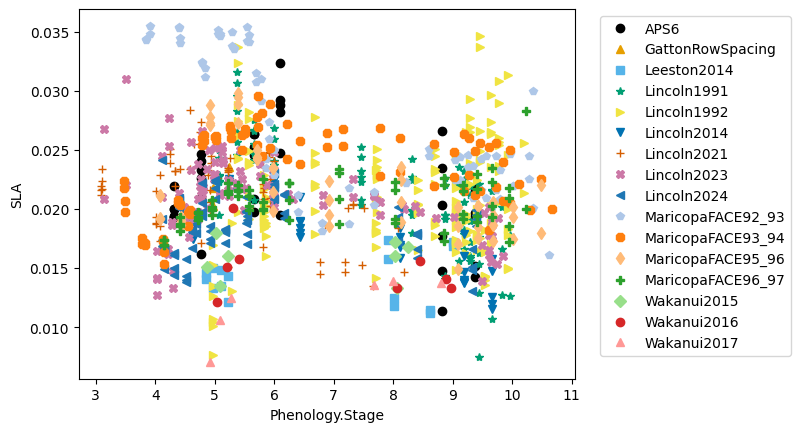

In [76]:
vars = ['Wheat.Leaf.SpecificAreaCanopy','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.SpecificAreaCanopy'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('SLA')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

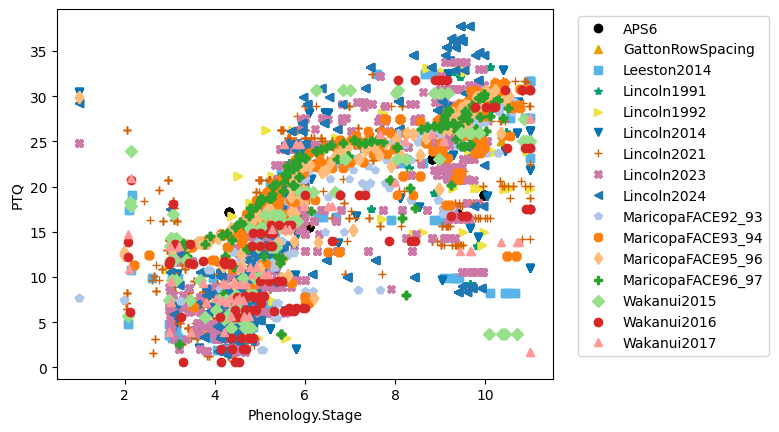

In [82]:
#xv = 'Wheat.Phenology.PTQ'
xv = 'IWeather.Radn'
vars = [xv,'Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,xv],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('PTQ')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

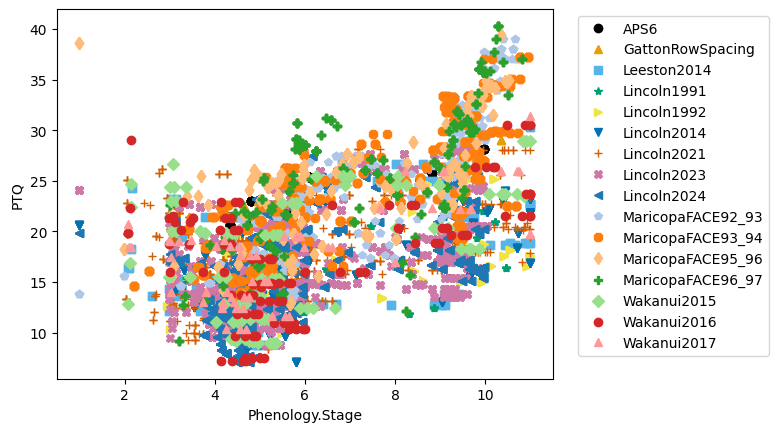

In [78]:
vars = ['IWeather.MaxT','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'IWeather.MaxT'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('PTQ')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'Phenology.Stage')

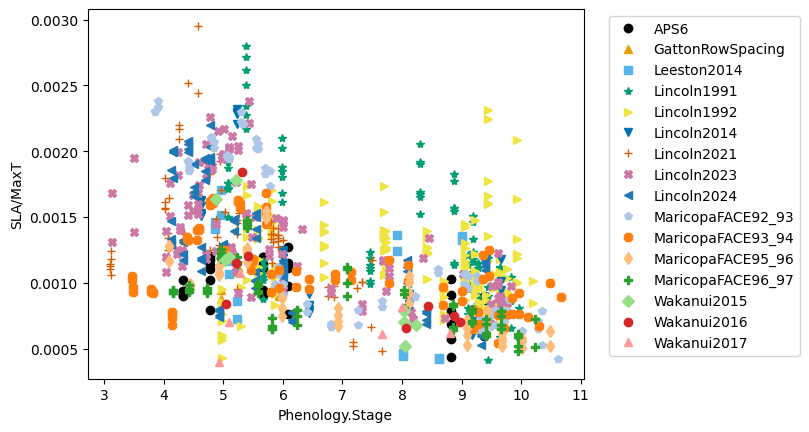

In [66]:
vars = ['Wheat.Leaf.SpecificAreaCanopy','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.SpecificAreaCanopy']/exData.loc[:,'IWeather.MaxT'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('SLA/MaxT')
plt.xlabel('Phenology.Stage')

Text(0.5, 0, 'AccumT')

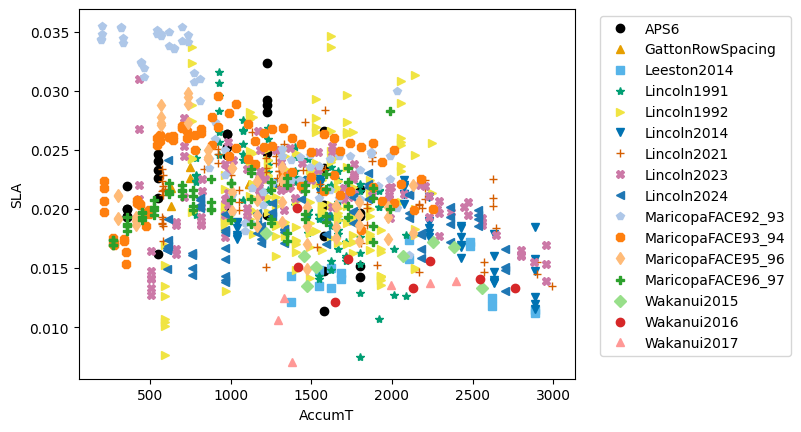

In [73]:
vars = ['Wheat.Leaf.SpecificAreaCanopy','Wheat.Phenology.AccumulatedTT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.AccumulatedTT'],exData.loc[:,'Wheat.Leaf.SpecificAreaCanopy'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
plt.ylabel('SLA')
plt.xlabel('AccumT')

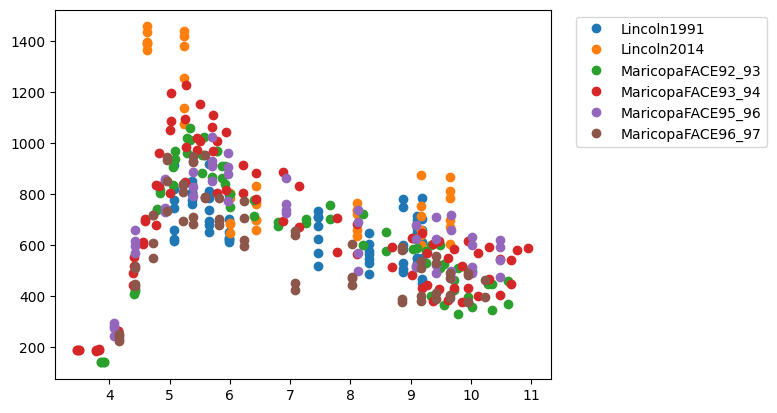

In [57]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation'],'o',label=e)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

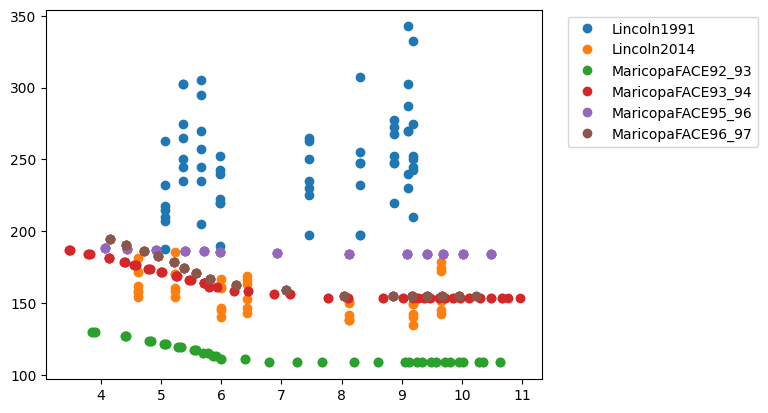

In [58]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Population'],'o',label=e)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

In [59]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTt']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation']/exData.loc[:,'Wheat.Population'],'o',label=e)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

KeyError: "['Wheat.Phenology.AccumulatedTt'] not in index"

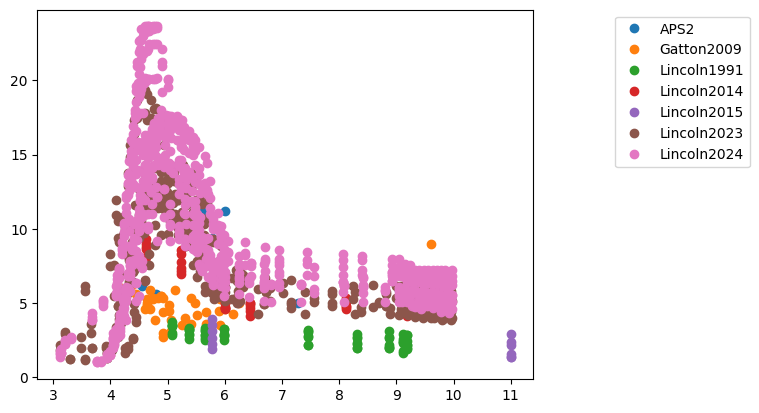

In [55]:
vars = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage','IWeather.MaxT']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],'o',label=e)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

In [29]:
data

,,Wheat.Spike.Wt,Wheat.Stem.Wt,Experiment
SimulationName,Clock.Today,,,
Ginninderra1991N0CvJanz,1991-11-05 12:00:00,196.000000,632.000000,Ginninderra1991
Ginninderra1991N120CvJanz,1991-11-05 12:00:00,239.000000,662.000000,Ginninderra1991
Ginninderra1991N160CvJanz,1991-11-05 12:00:00,236.000000,665.000000,Ginninderra1991
Ginninderra1991N200CvJanz,1991-11-05 12:00:00,250.000000,681.000000,Ginninderra1991
Ginninderra1991N240CvJanz,1991-11-05 12:00:00,244.000000,664.000000,Ginninderra1991
...,...,...,...,...
Wakanui2016Sow24-FebCmNormal,2017-02-10 12:00:00,302.655370,961.143017,Wakanui2016
Wakanui2016Sow29-MarCmNormal,2017-02-10 12:00:00,308.064917,1142.226750,Wakanui2016
Wakanui2017Sow09-MarCmNormal,2018-01-23 12:00:00,257.731855,659.985688,Wakanui2017
